*Question 3*

In [12]:
import numpy as np
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.manifold import TSNE
import seaborn as sns


(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize the data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Flatten the images
x_train_flat = x_train.reshape(-1, 28 * 28)
x_test_flat = x_test.reshape(-1, 28 * 28)

# Convert to PyTorch tensors and move to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
X_train_t = torch.tensor(x_train_flat).to(device)
Y_train_t = torch.tensor(y_train).to(device)
X_test_t = torch.tensor(x_test_flat).to(device)
Y_test_t = torch.tensor(y_test).to(device)

print(device)
print("Training set shape:", x_train_flat.shape)
print("Test set shape:", x_test_flat.shape)

cuda
Training set shape: (60000, 784)
Test set shape: (10000, 784)


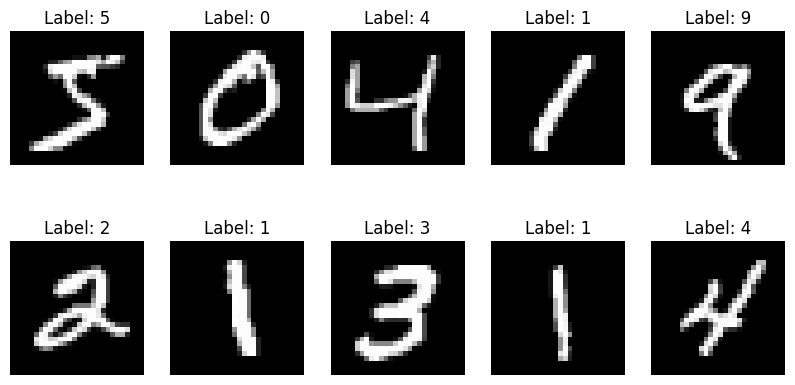

In [13]:
# Visualize a few samples from the training set
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.show()

In [15]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(28*28, 30)
        self.hidden2 = nn.Linear(30, 20)
        self.output = nn.Linear(20, 10)

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = self.output(x)
        return x

# Initialize and train the MLP
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()  # Using CrossEntropyLoss for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training settings
epochs = 100
batch_size = 64

for epoch in range(epochs):
    model.train()
    for i in range(0, len(X_train_t), batch_size):
        x_batch = X_train_t[i:i + batch_size]
        y_batch = Y_train_t[i:i + batch_size]

        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

    # Print training progress
    # print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}')

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_t)
    y_test_pred_classes = torch.argmax(y_test_pred, dim=1)

# Calculate F1-score and confusion matrix for MLP
f1_mlp = f1_score(Y_test_t.cpu(), y_test_pred_classes.cpu(), average='macro')
conf_matrix_mlp = confusion_matrix(Y_test_t.cpu(), y_test_pred_classes.cpu())

print(f"MLP F1 Score: {f1_mlp:.4f}")
print("MLP Confusion Matrix:")
print(conf_matrix_mlp)
print("MLP Classification Report:")
print(classification_report(Y_test_t.cpu(), y_test_pred_classes.cpu(), target_names=[str(i) for i in range(10)]))


MLP F1 Score: 0.9619
MLP Confusion Matrix:
[[ 962    0    2    2    2    2    5    1    4    0]
 [   0 1114    4    1    0    0    4    4    8    0]
 [   3    3  994    3    6    0    6   12    5    0]
 [   0    1   11  962    3   18    0    7    5    3]
 [   2    0    4    0  940    1    5    9    1   20]
 [   5    1    2    7    2  860    6    3    4    2]
 [  11    3    2    0    9   11  921    0    1    0]
 [   2    5   12    0    1    2    0  998    1    7]
 [   9    2    7   16    5    6    5    9  903   12]
 [   4    4    0    6    7    5    0   12    3  968]]
MLP Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.96      0.96      0.96      1032
           3       0.96      0.95      0.96      1010
           4       0.96      0.96      0.96       982
           5       0.95      0.96      0.96       892
           6       0

In [5]:

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(x_train_flat, y_train)

# Predict with Random Forest
y_pred_rf = rf_model.predict(x_test_flat)

# Calculate F1-score for RF
f1_rf = f1_score(y_test, y_pred_rf, average='macro')
print(f"Random Forest F1 Score: {f1_rf:.4f}")

# Confusion Matrix for Random Forest
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print("Random Forest Confusion Matrix:")
print(conf_matrix_rf)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=[str(i) for i in range(10)]))

# Train Logistic Regression Classifier
logreg_model = LogisticRegression(max_iter=500, solver='lbfgs')
logreg_model.fit(x_train_flat, y_train)

# Predict with Logistic Regression
y_pred_logreg = logreg_model.predict(x_test_flat)

# Calculate F1-score for Logistic Regression
f1_logreg = f1_score(y_test, y_pred_logreg, average='macro')
print(f"Logistic Regression F1 Score: {f1_logreg:.4f}")

# Confusion Matrix for Logistic Regression
conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)
print("Logistic Regression Confusion Matrix:")
print(conf_matrix_logreg)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logreg, target_names=[str(i) for i in range(10)]))


Random Forest F1 Score: 0.9702
Random Forest Confusion Matrix:
[[ 971    0    0    0    0    2    3    1    3    0]
 [   0 1127    2    2    0    1    2    0    1    0]
 [   6    0 1002    5    3    0    3    8    5    0]
 [   1    0    9  972    0    9    0    9    8    2]
 [   1    0    0    0  955    0    5    1    4   16]
 [   5    1    1    9    2  860    5    2    5    2]
 [   7    3    0    0    3    3  937    0    5    0]
 [   1    4   20    2    0    0    0  989    2   10]
 [   4    0    6    7    5    5    5    4  930    8]
 [   7    6    2   12   12    1    0    4    4  961]]
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.97      1032
           3       0.96      0.96      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.98      0.96      0.97 

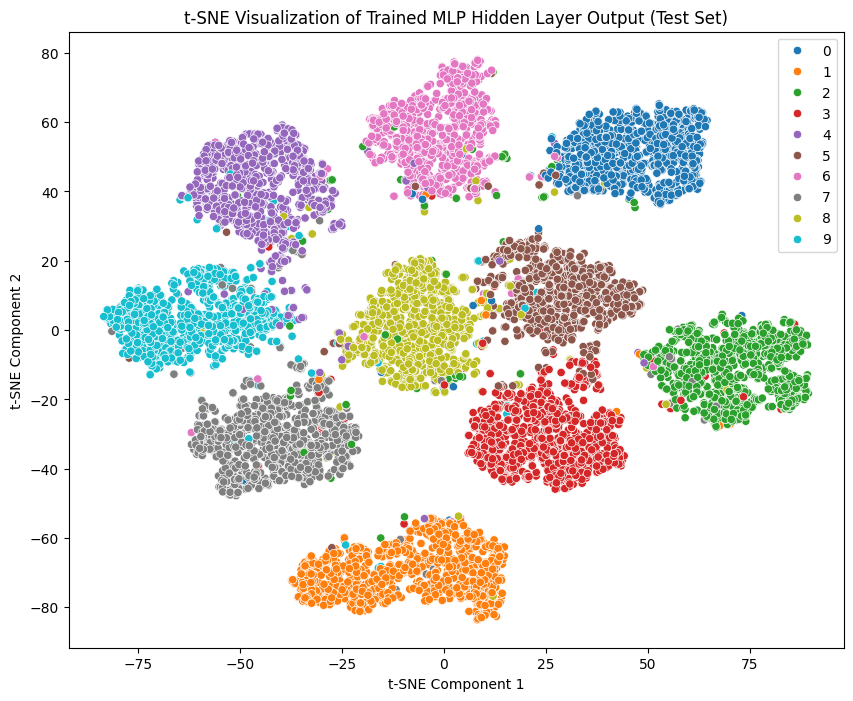

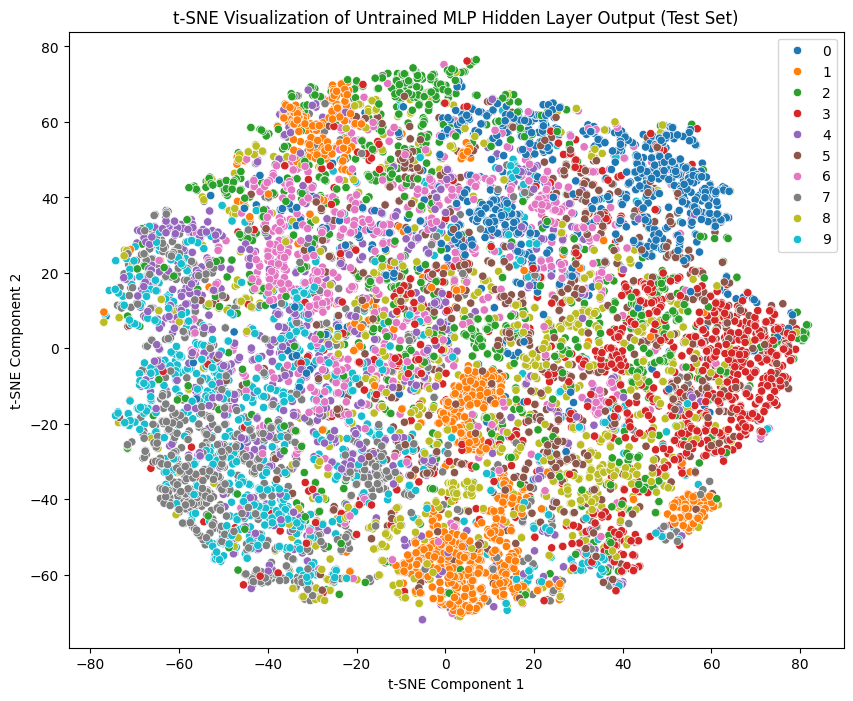

In [6]:

# t-SNE visualization for the trained MLP
model.eval()
with torch.no_grad():
    # Get outputs from the second hidden layer (20 neurons)
    hidden_layer_output_trained = torch.relu(model.hidden2(torch.relu(model.hidden1(X_test_t))))

# Prepare for t-SNE
hidden_layer_output_trained = hidden_layer_output_trained.cpu().numpy()
tsne_trained = TSNE(n_components=2, random_state=42)
hidden_layer_tsne_trained = tsne_trained.fit_transform(hidden_layer_output_trained)

# Plotting t-SNE for trained MLP
plt.figure(figsize=(10, 8))
sns.scatterplot(x=hidden_layer_tsne_trained[:, 0], y=hidden_layer_tsne_trained[:, 1], hue=y_test, palette='tab10', legend='full')
plt.title('t-SNE Visualization of Trained MLP Hidden Layer Output (Test Set)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

# Create an untrained model and get its hidden layer output
untrained_model = MLP().to(device)

with torch.no_grad():
    hidden_layer_output_untrained = torch.relu(untrained_model.hidden2(torch.relu(untrained_model.hidden1(X_test_t))))

# Prepare for t-SNE for untrained model
hidden_layer_output_untrained = hidden_layer_output_untrained.cpu().numpy()
hidden_layer_tsne_untrained = tsne_trained.fit_transform(hidden_layer_output_untrained)

# Plotting t-SNE for untrained MLP
plt.figure(figsize=(10, 8))
sns.scatterplot(x=hidden_layer_tsne_untrained[:, 0], y=hidden_layer_tsne_untrained[:, 1], hue=y_test, palette='tab10', legend='full')
plt.title('t-SNE Visualization of Untrained MLP Hidden Layer Output (Test Set)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


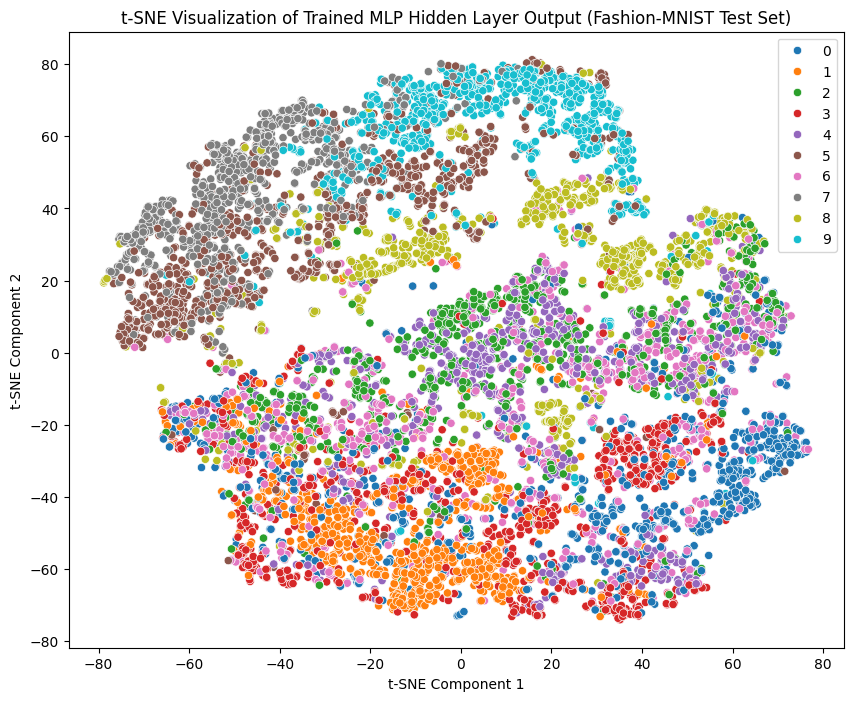

In [7]:
# Load Fashion-MNIST dataset using TensorFlow
(fashion_x_train, fashion_y_train), (fashion_x_test, fashion_y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize the data
fashion_x_train = fashion_x_train.astype('float32') / 255.0
fashion_x_test = fashion_x_test.astype('float32') / 255.0

# Flatten the images
fashion_x_train_flat = fashion_x_train.reshape(-1, 28 * 28)
fashion_x_test_flat = fashion_x_test.reshape(-1, 28 * 28)

# Convert Fashion-MNIST data to PyTorch tensors and move to GPU if available
fashion_X_test_t = torch.tensor(fashion_x_test_flat).to(device)
fashion_Y_test_t = torch.tensor(fashion_y_test).to(device)

# Use the trained MLP to predict on Fashion-MNIST
model.eval()
with torch.no_grad():
    # Get outputs from the second hidden layer (20 neurons)
    fashion_hidden_layer_output_trained = torch.relu(model.hidden2(torch.relu(model.hidden1(fashion_X_test_t))))

# Prepare for t-SNE
fashion_hidden_layer_output_trained = fashion_hidden_layer_output_trained.cpu().numpy()
tsne_fashion = TSNE(n_components=2, random_state=42)
fashion_hidden_layer_tsne_trained = tsne_fashion.fit_transform(fashion_hidden_layer_output_trained)

# Plotting t-SNE for Fashion-MNIST embeddings from the trained MLP
plt.figure(figsize=(10, 8))
sns.scatterplot(x=fashion_hidden_layer_tsne_trained[:, 0], y=fashion_hidden_layer_tsne_trained[:, 1], hue=fashion_y_test, palette='tab10', legend='full')
plt.title('t-SNE Visualization of Trained MLP Hidden Layer Output (Fashion-MNIST Test Set)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

Fashion-MNIST Test Accuracy: 0.0423


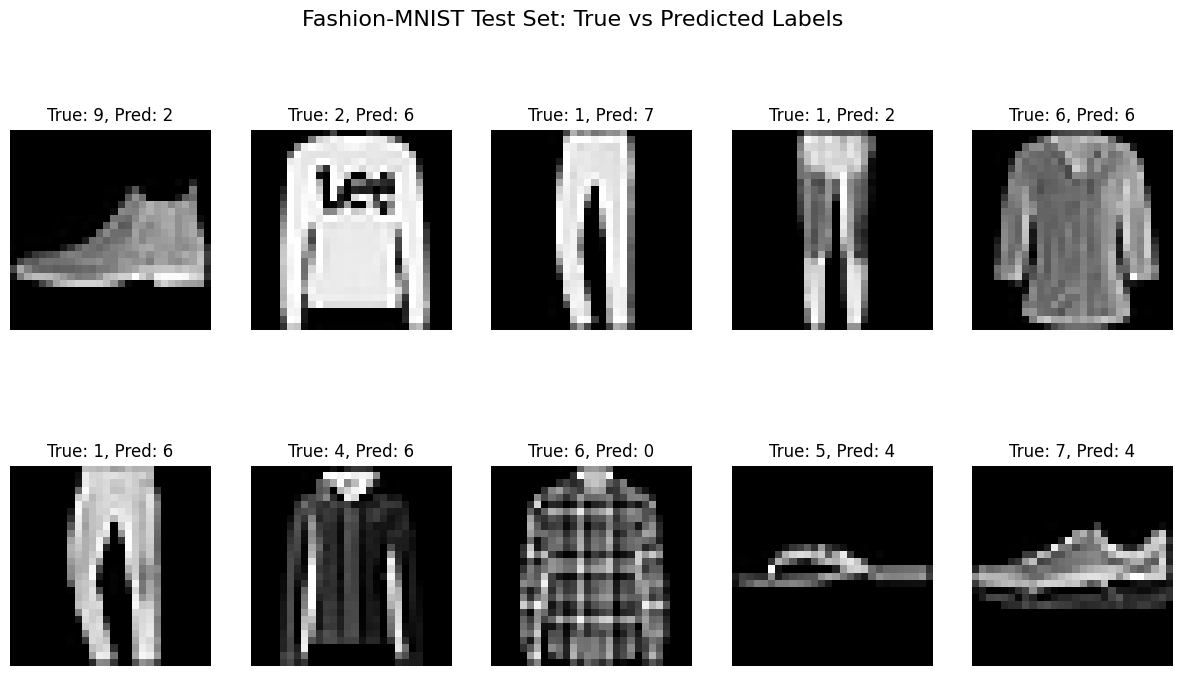

True Labels vs Predicted Labels for First 10 Samples:
Sample 1: True Label = 9, Predicted Label = 2
Sample 2: True Label = 2, Predicted Label = 6
Sample 3: True Label = 1, Predicted Label = 7
Sample 4: True Label = 1, Predicted Label = 2
Sample 5: True Label = 6, Predicted Label = 6
Sample 6: True Label = 1, Predicted Label = 6
Sample 7: True Label = 4, Predicted Label = 6
Sample 8: True Label = 6, Predicted Label = 0
Sample 9: True Label = 5, Predicted Label = 4
Sample 10: True Label = 7, Predicted Label = 4


In [21]:
import numpy as np
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns

# Load Fashion-MNIST dataset using TensorFlow
(fashion_x_train, fashion_y_train), (fashion_x_test, fashion_y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize the data
fashion_x_train = fashion_x_train.astype('float32') / 255.0
fashion_x_test = fashion_x_test.astype('float32') / 255.0

# Flatten the images
fashion_x_train_flat = fashion_x_train.reshape(-1, 28 * 28)
fashion_x_test_flat = fashion_x_test.reshape(-1, 28 * 28)

# Convert Fashion-MNIST data to PyTorch tensors and move to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
fashion_X_test_t = torch.tensor(fashion_x_test_flat).to(device)
fashion_Y_test_t = torch.tensor(fashion_y_test).to(device)

# Use the trained MLP to predict on Fashion-MNIST
model.eval()
with torch.no_grad():
    y_fashion_test_pred = model(fashion_X_test_t)
    y_fashion_test_pred_classes = torch.argmax(y_fashion_test_pred, dim=1)

# Convert PyTorch tensors to numpy arrays for easy manipulation
y_fashion_test_pred_classes = y_fashion_test_pred_classes.cpu().numpy()

# Calculate accuracy
accuracy = accuracy_score(fashion_y_test, y_fashion_test_pred_classes)
print(f"Fashion-MNIST Test Accuracy: {accuracy:.4f}")

# Display the first 10 test images, true labels, and predicted labels
num_samples = 10
plt.figure(figsize=(15, 8))
for i in range(num_samples):
    plt.subplot(2, 5, i + 1)
    plt.imshow(fashion_x_test[i], cmap='gray')
    plt.title(f"True: {fashion_y_test[i]}, Pred: {y_fashion_test_pred_classes[i]}")
    plt.axis('off')

plt.suptitle('Fashion-MNIST Test Set: True vs Predicted Labels', fontsize=16)
plt.show()

# Print the true labels and predicted labels side by side for the first 10 samples
print("True Labels vs Predicted Labels for First 10 Samples:")
for i in range(num_samples):
    print(f"Sample {i + 1}: True Label = {fashion_y_test[i]}, Predicted Label = {y_fashion_test_pred_classes[i]}")
